# Example: Delta Hedging of a LP Position

**Setup:**
- There is an external price (e.g. CEX) whose dynamic is given by a GBM.
- There is an arbitrager who exploits the price discrepency betweeen the pool and an external market (e.g. CEX).
- There is a noise trader that generates random transactions. This agent is irrelevant if we only care about hedging, it only matters if we want to simulate swap fees.
- The initial liquidity in the pool is flat (for simplicity but it can be made arbitrary).
- Our agent opens a liquidity position and hedges the market risk. There is no adjustment of the LP position.
- There is no friction:
  - no funding rate,
  - no fees, and
  - no bid-ask spread.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import plotnine as p9
from dex_sim.pool import Pool
from dex_sim.agents import StaticLiquidityProvider, HedgedStaticLiquidityProvider, Arbitrager, NoiseTrader
from dex_sim.price import PriceSimulator
from dex_sim.trackers import PoolTracker, LPAgentTracker

# Set up logging
import logging
logger = logging.getLogger('environ')
logger.setLevel(logging.INFO)

seed = 123

## Initialize Pool, Arbitrager, Noise Trader, and Liquidity Provider

In [3]:
# Initialize the pool
pool = Pool(price=3000, fee=0.00, token0="ETH", token1="USDC")
print(f"Initialize empty pool: {pool}")

# Add a position to the pool
position = pool.add_position(lower_price=1000, upper_price=10000, liquidity=100_000, is_tracked=False)
print(f"Add position to pool: {position}")

# Initialize the arbitrager
arbitrager = Arbitrager(name="Arbitrager", tolerance=0.01)
print(f"Initialize arbitrager: {arbitrager}")

# Initialize the NoiseTrader
noise_trader = NoiseTrader(name="NoiseTraderTest", poisson_lambda=1, gaussian_mean=0, gaussian_std=1, seed=seed)
print(f"Initialize noise trader: {noise_trader}")

# Initialize the LiquidityProvider
liquidity_provider1 = HedgedStaticLiquidityProvider(name="HedgedLP", amount0=10, amount1=30000, leverage=10)
print(f"Initialize liquidity provider 1: {liquidity_provider1}")
liquidity_provider2 = StaticLiquidityProvider(name="UnhedgedLP", amount0=10, amount1=30000, leverage=10)
print(f"Initialize liquidity provider 2: {liquidity_provider2}")

Initialize empty pool: Pool(price=3000.00, fee=0.0, token0=ETH, token1=USDC)
Add position to pool: Position(id=0, lower_price=1000.00, upper_price=10000.00, liquidity=100000.00, is_tracked=False)
Initialize arbitrager: <dex_sim.agents.Arbitrager object at 0x11017f680>
Initialize noise trader: <dex_sim.agents.NoiseTrader object at 0x1230af440>
Initialize liquidity provider 1: <dex_sim.agents.HedgedStaticLiquidityProvider object at 0x1104d4440>
Initialize liquidity provider 2: <dex_sim.agents.StaticLiquidityProvider object at 0x11017c410>


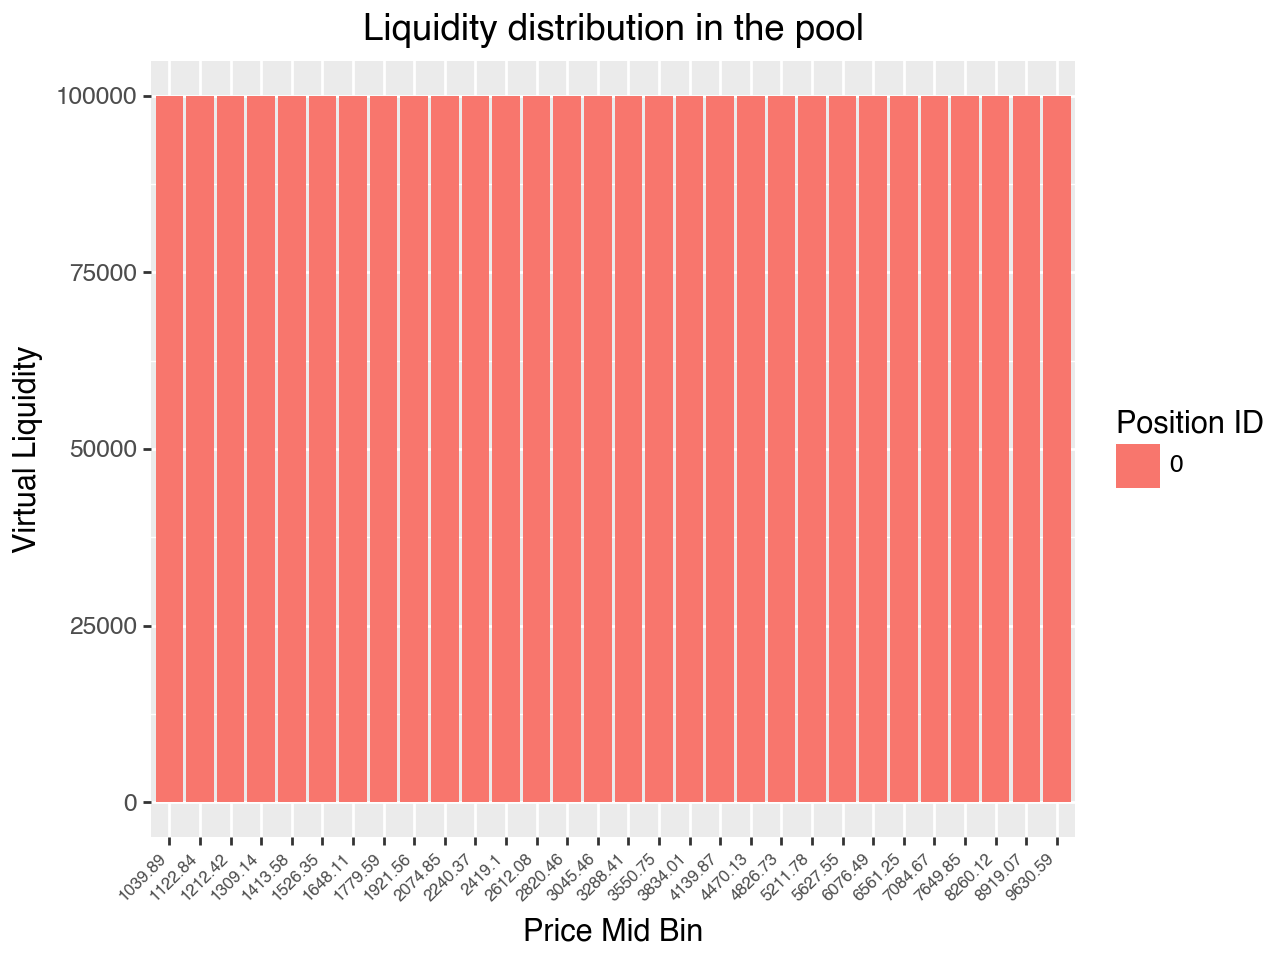

In [5]:
from dex_sim.helper import plot_pool_liquidity_distribution

plot_pool_liquidity_distribution(pool)

## Simulate a Price Trajectory

In [6]:
# Initialize the price simulator
simulator = PriceSimulator(initial_price=3000, mu=0.0, sigma=0.005, dt=1, seed=seed)  # 1% hourly volatility ~ 100% annual volatility
print(f"Initialize price simulator: {simulator}")

# Simulate price changes over a month (24 hours * 30 days)
cex_prices = simulator.simulate(steps=24*30)
print("Simulated price changes over time. First price = {:.2f}, Last price = {:.2f}".format(cex_prices[0], cex_prices[-1]))

Initialize price simulator: <dex_sim.price.PriceSimulator object at 0x127518f50>
Simulated price changes over time. First price = 3000.00, Last price = 2955.34


## Simulate Arbitrager and Liquidity Provider Actions

In [7]:
# Simulate the actions of the LiquidityProvider in response to the price changes
pool_tracker = PoolTracker(pool)
lp1_tracker = LPAgentTracker(liquidity_provider1)
lp2_tracker = LPAgentTracker(liquidity_provider2)

for timestep, external_price in enumerate(cex_prices):
    noise_trader.act(pool)
    arbitrager.act(pool, external_price)
    liquidity_provider1.act(pool, external_price)
    liquidity_provider2.act(pool)
    # trackers
    pool_tracker.update(pool, timestep)
    lp1_tracker.update(liquidity_provider1, pool, timestep)
    lp2_tracker.update(liquidity_provider2, pool, timestep)

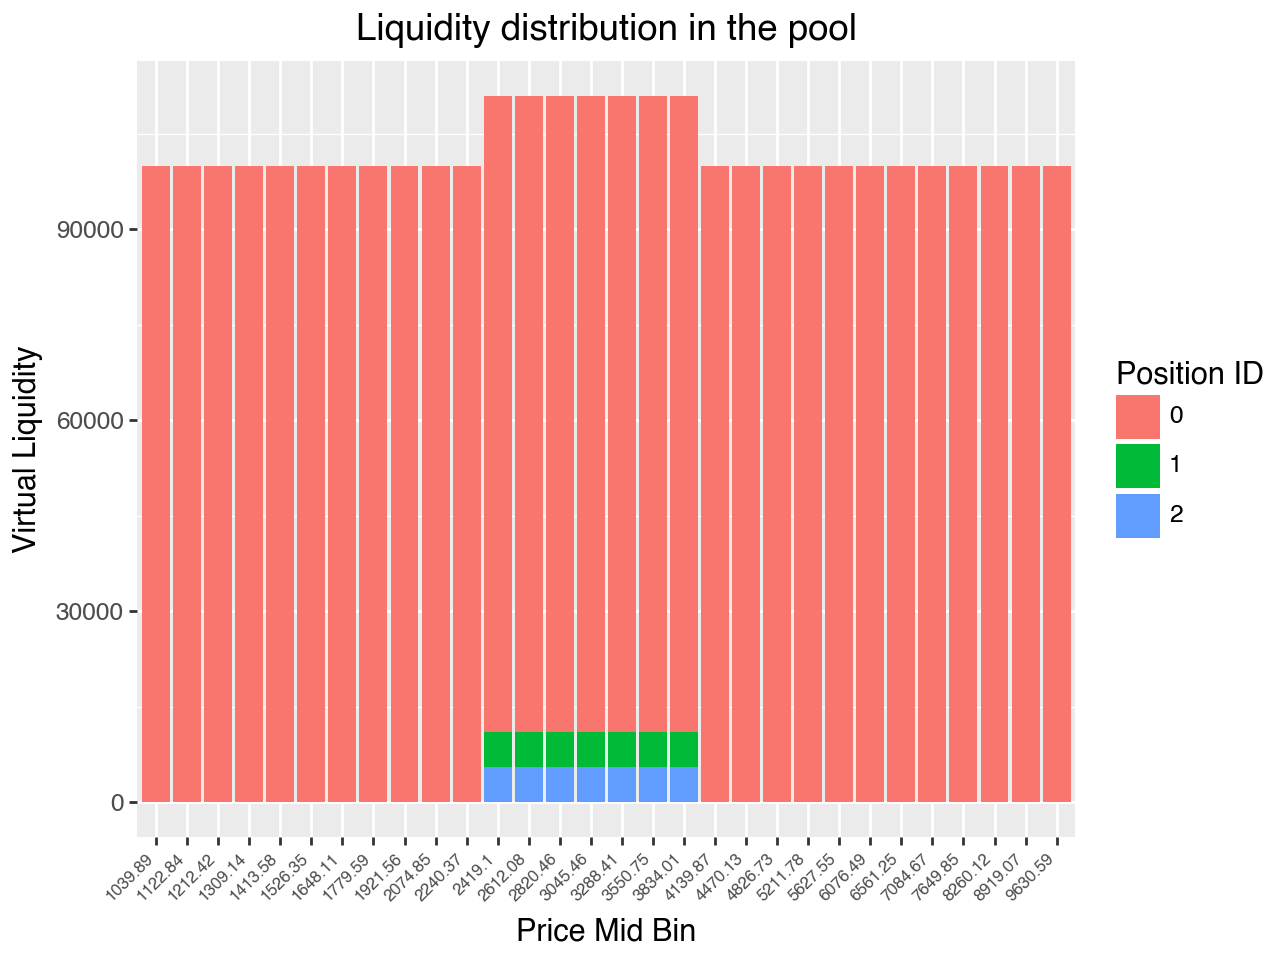

In [8]:
plot_pool_liquidity_distribution(pool)

In [9]:
def get_total_amounts(tracker):
    wallet_df,  positions_df = tracker.to_dataframe()
    amounts_in_positions = positions_df[positions_df.liquidity > 0][['timestep', 'amount_token0', 'amount_token1']]
    amounts_in_positions.columns = ['timestep', 'token0', 'token1']
    amounts_in_positions.set_index('timestep', inplace=True)
    amounts_in_wallet = wallet_df[['timestep', 'amount0', 'amount1']]
    amounts_in_wallet.columns = ['timestep', 'token0', 'token1']
    amounts_in_wallet.set_index('timestep', inplace=True)
    amounts = amounts_in_positions + amounts_in_wallet
    return amounts

pool_df = pool_tracker.to_dataframe()
lp1_amounts = get_total_amounts(lp1_tracker)
lp2_amounts = get_total_amounts(lp2_tracker)

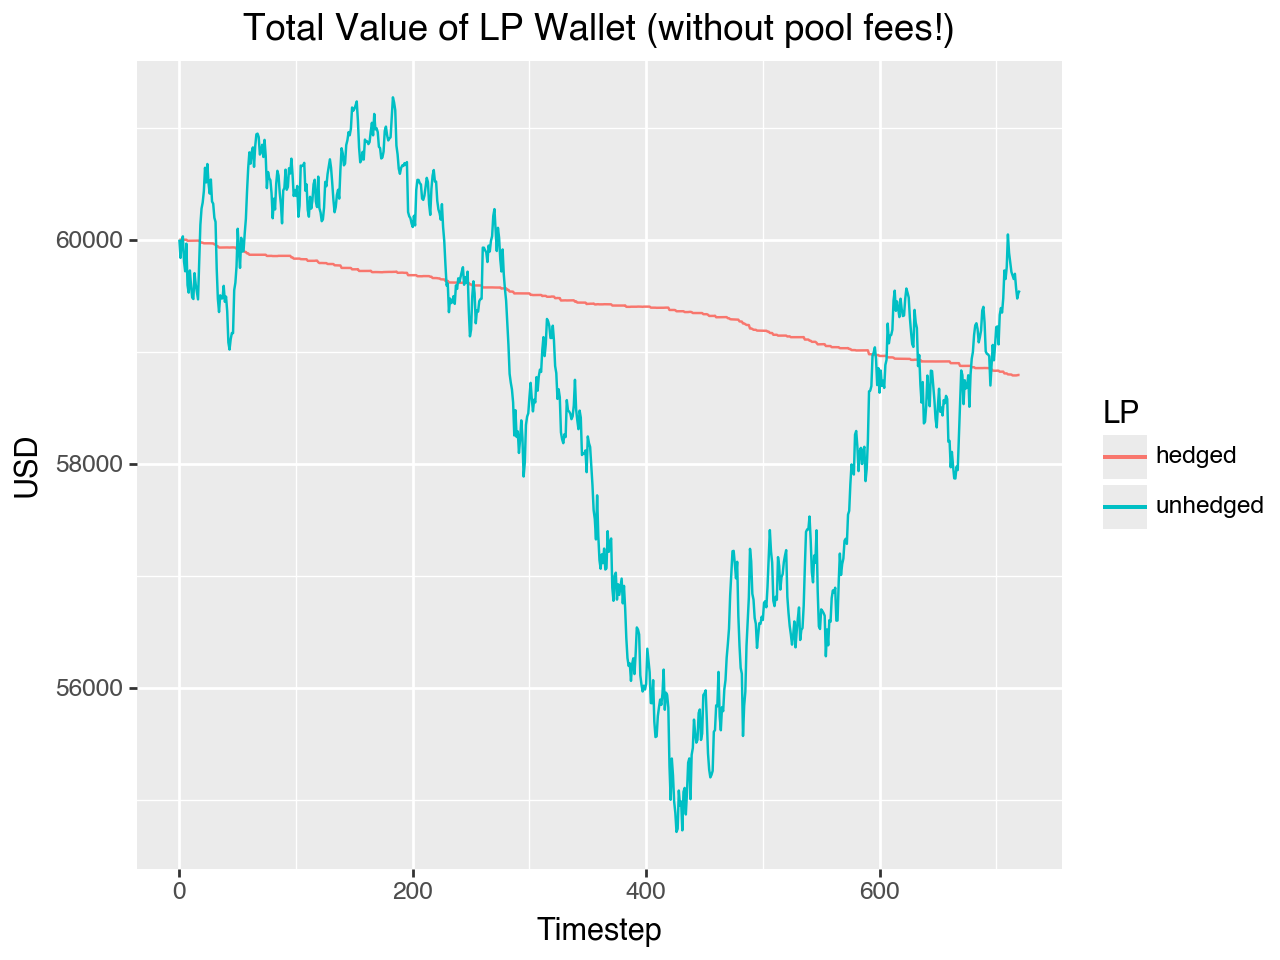

In [10]:
df = pd.concat([
    (lp1_amounts['token0'] * cex_prices + lp1_amounts['token1']).to_frame('hedged'),
    (lp2_amounts['token0'] * cex_prices + lp2_amounts['token1']).to_frame('unhedged'),
], axis=1).reset_index(drop=False)
df_long = df.melt(id_vars='timestep', var_name='lp', value_name='total_value')

p = (
    p9.ggplot(df_long) +
    p9.aes(x='timestep', y='total_value', color='lp') +
    p9.geom_line() +
    p9.ggtitle("Total Value of LP Wallet (without pool fees!)") +
    p9.xlab("Timestep") +
    p9.ylab("USD") +
    p9.labs(color="LP")
)

display(p)

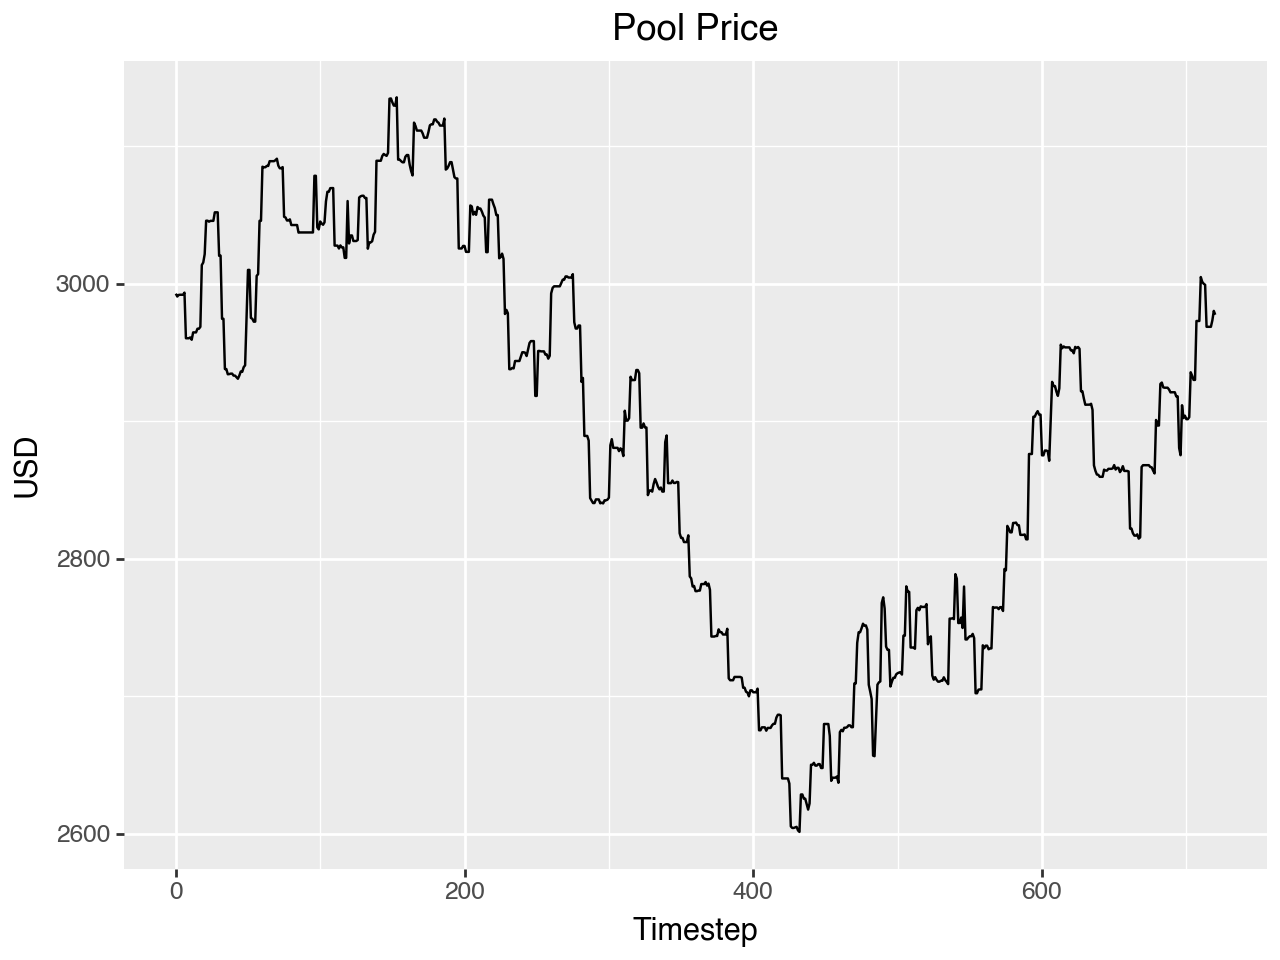

In [11]:
# display price
p = (
    p9.ggplot(pool_df) +
    p9.aes(x='timestep', y='price') +
    p9.geom_line() +
    p9.ggtitle("Pool Price") +
    p9.xlab("Timestep") +
    p9.ylab("USD")
)
p

/var/folders/1n/px68gf0s0d30s0p5010q1_y40000gn/T/ipykernel_61796/526106426.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


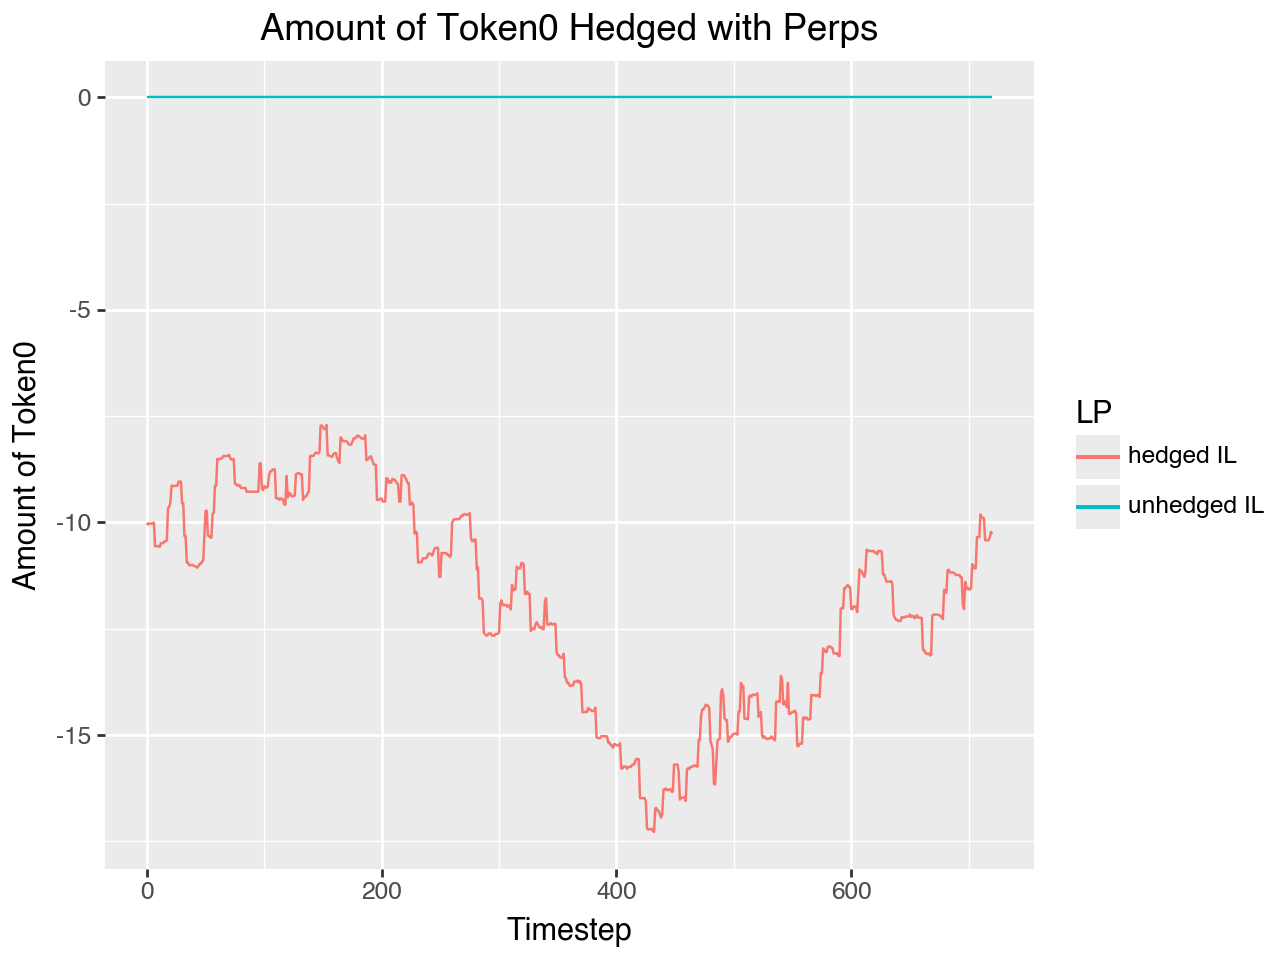

In [12]:
def get_hedged_amount0(tracker):
    wallet_df,  _ = tracker.to_dataframe()
    hedged_amounts = wallet_df[['timestep', 'amount0_hedged']]
    hedged_amounts.columns = ['timestep', 'token0']
    hedged_amounts.set_index('timestep', inplace=True)
    return hedged_amounts

lp1_hedged_amounts = get_hedged_amount0(lp1_tracker)
lp2_hedged_amounts = get_hedged_amount0(lp2_tracker)

df = pd.concat([
    lp1_hedged_amounts.rename(columns={'token0': 'hedged IL'}),
    lp2_hedged_amounts.rename(columns={'token0': 'unhedged IL'}),
], axis=1).reset_index(drop=False).replace(np.nan, 0)
df_long = df.melt(id_vars='timestep', var_name='lp', value_name='token0')

p = (
    p9.ggplot(df_long) +
    p9.aes(x='timestep', y='token0', color='lp') +
    p9.geom_line() +
    p9.ggtitle("Amount of Token0 Hedged with Perps") +
    p9.xlab("Timestep") +
    p9.ylab("Amount of Token0") +
    p9.labs(color="LP")
)

display(p)